<a href="https://colab.research.google.com/github/ChengyangHuang/Personalized_Regression/blob/main/Simulation_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from scipy.spatial import KDTree
from scipy.spatial import distance_matrix

import torch

# np.random.seed(0)


def generate_data(N, P, K, sigma_eps):
    X = np.random.uniform(-1, 1, size=(N, P))
    U = np.random.uniform(0, 1, size=(N, K))
    a = (np.abs(U-0.5)>0.25) + 0.1*np.sin(3*np.pi*U)
    theta = np.concatenate((U, a), axis=1)

    w = np.random.normal(0, sigma_eps, size=(N, K))
    # Y = np.diag(np.dot(X, theta.T)).reshape((N, K)) + w
    Y = np.sum(np.multiply(X, theta), axis=1, keepdims=True)
    return X, Y, theta, U 


def plot_parameters(theta_gt, theta_est, PR=False):
    fig, ax = plt.subplots(1)
    idxs = np.linspace(0, theta_gt.shape[0]-1, 100, dtype=int)
    ax.scatter(theta_gt[idxs, 0], theta_gt[idxs, 1], label="True Parameters")
    if PR:
        ax.scatter(theta_est[idxs, 0], theta_est[idxs, 1], label="EST. Parameters")
    else:
        ax.scatter(theta_est[:, 0], theta_est[:, 1], label="EST. Parameters")
    ax.legend()
    return fig, ax


def print_metrics(dic):
    message = f"\n"
    for k, v in dic.items():
        message += f"{k}:\t{v}\n"
    print(message)


def evaluate_method(y_pred, y_test, theta_pred, theta_train, method_name):
    mse = mean_squared_error(y_test, y_pred)
    R2 = r2_score(y_test, y_pred)
    dtheta_norm2 = np.linalg.norm(theta_pred-theta_train, ord=2) if method_name == "Personalized Regression" or method_name == "Linear Regression" else "TODO"
    performance_dict = {"method_name": method_name,
                        "MSE": mse,
                        "R2": R2,
                        "dtheta_n2": dtheta_norm2
                        }
    return performance_dict

In [8]:
class PRRegressor():
    def __init__(self, args, theta_pop, trainset, evalset=None, theta_train=None):
        # Training Parameters
        self.cov_norm_ord = args.covariate_norm_ord

        self.sigma_theta = args.sigma_theta
        self.lambd = args.theta_regularizer
        self.gamma = args.distance_regularizer
        self.nu = args.phi_regularizer
        self.alpha = args.learning_rate
        self.c = args.lr_decay
        self.q = args.latent_dim
        self.k = args.covariate_dim
        self.log_steps = args.log_steps
        self.n_neighbors = args.n_neighbors
        self.show_logs = args.show_logs
        self.use_distance_loss = args.use_distance_loss

        self.theta_pop = torch.from_numpy(theta_pop).flatten()
        self.n_features, self.n_outputs = theta_pop.shape

        # Training Data
        X_train, y_train, U_train = trainset
        self.X_train = torch.from_numpy(X_train)
        self.y_train = torch.from_numpy(y_train).to(dtype=torch.double)
        self.__init_U_train(U_train)
        self.n = self.X_train.shape[0]

        # Validation Data
        if type(evalset) != "NoneType":
            self.eval = True
            self.X_eval, self.y_eval, self.U_eval = evalset
        else: 
            self.eval = False
        self.theta_train = theta_train

        # Variable Initialization
        PI = np.random.multivariate_normal(theta_pop.flatten(), self.sigma_theta*np.eye(self.n_features*self.n_outputs), size=self.n)
        self.PI = torch.from_numpy(PI)
        self.Z, self.Q = self.__init_ZnQ(PI)
        self.phi = torch.ones((self.k, ), dtype=torch.float64) / self.k

        # Loss Functions
        self.__sample_specific_loss = torch.nn.MSELoss(reduction="sum")
        self.__parameter_regularizer = torch.nn.L1Loss()
        self.__phi_regularizer = torch.nn.MSELoss()
        self.__distance_loss = torch.nn.MSELoss()


    def train(self, n_epoch=5):
        for epoch in range(n_epoch):
            # Require Gradient for variables
            Z = self.Z.clone().requires_grad_(True)
            Q = self.Q.clone().requires_grad_(True)
            phi = self.phi.clone().requires_grad_(True)
            PI = self.__update_PI(Z, Q) 

            y_pred = self.__predict(self.X_train, PI)

            # Calculate Loss
            l_loss = self.__sample_specific_loss(y_pred, self.y_train)
            D_loss = self.__distance_matching_regularizer(Z, phi) if self.use_distance_loss else 0
            theta_loss = self.__parameter_regularizer(PI, torch.zeros_like(PI))
            phi_sum = torch.sum(phi, dim=0, keepdim=True)
            phi_loss = self.__phi_regularizer(phi_sum, torch.ones_like(phi_sum)) # Weight should sum to one
            loss = l_loss + self.gamma * D_loss + self.lambd * theta_loss + self.nu * phi_loss
            
            # Update phi
            loss.backward()
            self.phi -= self.alpha * phi.grad

            # Update Z
            alpha_cust = self.alpha / torch.linalg.norm(self.PI-self.theta_pop, 
                                                        float('inf'), dim=1, keepdim=True)
            self.Z -= torch.bmm(Z.grad.unsqueeze(2), alpha_cust.unsqueeze(2)).squeeze()

            # Update Q
            self.Q -= self.alpha * Q.grad

            # Update alpha
            self.alpha *= self.c

            # Update theta, PI
            self.PI = self.__update_PI(self.Z, self.Q)

            if self.show_logs and epoch % self.log_steps == 0:
                message = f"Epoch {epoch+1} - Total loss: {loss}\tDistance loss:{D_loss}"
                print("-"*20)
                print(message)
                if self.eval:
                    y_pred = self.predict(self.X_eval, self.U_eval)
                    print_metrics(evaluate_method(y_pred, self.y_eval, self.PI.numpy(), self.theta_train, "Personalized Regression"))
                print("-"*20)
        

    def predict(self, X_test, U_test):
        X = torch.from_numpy(X_test)
        dist_mat_test = self.__create_distance_matrix(self.U_train.numpy(), U_test)
        _, idx_sets = torch.matmul(dist_mat_test, self.phi).topk(self.n_neighbors, dim=1, largest=False)
        PI = self.PI[idx_sets, :].mean(axis=1)
        y_pred = self.__predict(X, PI).detach().numpy()
        return y_pred


    def __predict(self, X, PI):
        pred = torch.bmm(X.unsqueeze(1), PI.view(-1, self.n_features, self.n_outputs)).squeeze(dim=2)
        return pred


    def __create_distance_matrix(self, A, B):
        dist_mat = []
        for i in range(A.shape[1]):
            dist_mat.append(distance_matrix(A[:, [i]], B[:, [i]], p=self.cov_norm_ord))
        dist_mat = torch.from_numpy(np.array(dist_mat)).T
        return dist_mat


    def __init_U_train(self, U_train: np.array):
        self.U_train = torch.from_numpy(U_train)
        self.U_distance_mat = self.__create_distance_matrix(U_train, U_train)


    def __init_ZnQ(self, PI):
        pca = PCA(n_components=self.q, whiten=False)
        Z = pca.fit_transform(PI)
        Q = pca.components_
        return torch.from_numpy(Z), torch.from_numpy(Q)
    

    def __update_PI(self, Z, Q):
        return torch.mm(Z, Q) + self.theta_pop
    

    def __distance_matching_regularizer(self, Z, phi):
        _Z = Z.detach().numpy()
        tree = KDTree(_Z)
        _, idx_set = tree.query(_Z, k=6)
        idx_set = idx_set[:, 1:]
        Z_set = Z[idx_set, :]
        delta_Z = Z.view(Z.shape[0], 1, -1).expand(-1, Z_set.shape[1], -1) - Z_set
        delta_Z = torch.linalg.norm(delta_Z, ord=2, dim=2)

        U_dist_idx = torch.from_numpy(idx_set).to(dtype=torch.int64).view(idx_set.shape[0], -1, 1).expand(-1, -1, self.k)
        U_dist_set = torch.gather(self.U_distance_mat, 1, U_dist_idx)
        rho_U = torch.matmul(U_dist_set, phi)
        d_loss = self.__distance_loss(delta_Z, rho_U)
        return d_loss


--------------------
Epoch 1 - Total loss: 69.59610970620875	Distance loss:0

method_name:	Personalized Regression
MSE:	0.10670583757894246
R2:	0.6668691847099075
dtheta_n2:	11.06708957829234

--------------------
--------------------
Epoch 101 - Total loss: 0.4091288566050408	Distance loss:0

method_name:	Personalized Regression
MSE:	0.04497084789790536
R2:	0.8596030398671237
dtheta_n2:	7.414237660828522

--------------------
--------------------
Epoch 201 - Total loss: 0.08162939145726317	Distance loss:0

method_name:	Personalized Regression
MSE:	0.04278872663671375
R2:	0.8664155240881938
dtheta_n2:	7.305576092963297

--------------------
--------------------
Epoch 301 - Total loss: 0.03328217483128607	Distance loss:0

method_name:	Personalized Regression
MSE:	0.0420445450028665
R2:	0.8687388256060141
dtheta_n2:	7.27421191058586

--------------------
--------------------
Epoch 401 - Total loss: 0.02042277406043715	Distance loss:0

method_name:	Personalized Regression
MSE:	0.041676223

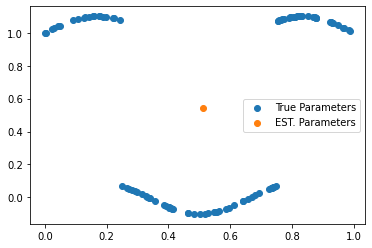

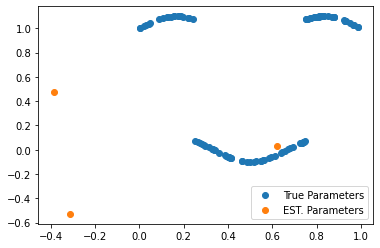

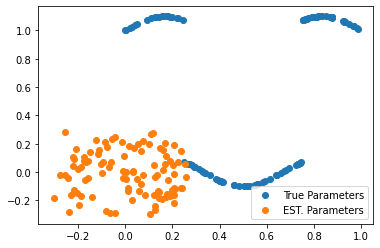

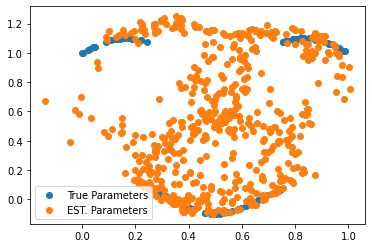

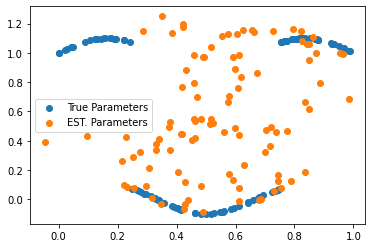

In [9]:
class Data_Arguments():
    N_train = 500
    N_test = 1000
    P = 2
    K = 1
    sigma_eps = 0.001


class PR_Arguments():
    # Data Arguments
    sigma_theta = 0.001
    theta_regularizer = 0.01
    distance_regularizer = 0.01
    phi_regularizer = 0

    # 
    n_neighbors = 3
    latent_dim = 2
    covariate_dim = 1
    covariate_norm_ord = 2
    covariate_x_start = 2
    covariate_x_end = -1

    # Traing Arguments
    learning_rate = 4e-3
    lr_decay = 1-1e-4
    n_epoch = 2000 #2000
    log_steps = 100
    show_logs = True
    use_distance_loss = False


def main():
    args = Data_Arguments()
    
    X_train, y_train, theta_train, U_train  = generate_data(args.N_train, args.P, args.K, args.sigma_eps)
    X_test, y_test, theta_test, U_test = generate_data(args.N_test, args.P, args.K, args.sigma_eps)

    result_list = []
    ## Linear Regression
    lr = LinearRegression().fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    theta_lr = np.array(lr.coef_)
    dict_lr = evaluate_method(y_pred_lr, y_test, theta_lr, theta_train, "Linear Regression")
    result_list.append((theta_lr, dict_lr))

    ## Other Baseline methods
    ## GMM
    gmm = GaussianMixture(3, max_iter=100).fit(X_train, y_train)
    # gmm = BayesianGaussianMixture(3).fit(X_train, y_train)
    y_pred_gmm = gmm.predict(X_test)
    theta_gmm = np.array(gmm.means_)
    dict_gmm = evaluate_method(y_pred_gmm, y_test, theta_gmm, theta_train, "Gaussian Mixture")
    result_list.append((theta_gmm, dict_gmm))

    ## DNN
    dnn = MLPRegressor(hidden_layer_sizes=(100,)).fit(X_train, y_train.squeeze())
    y_pred_dnn = dnn.predict(X_test)
    theta_dnn = np.array(dnn.coefs_[0].T)
    dict_dnn = evaluate_method(y_pred_dnn, y_test, theta_dnn, theta_train, "Deep Neural Networks")
    result_list.append((theta_dnn, dict_dnn))

    ## Personalized Regression
    pr_args = PR_Arguments()
    theta_lr = np.array(lr.coef_).T
    trainset = (X_train, y_train, U_train)
    evalset = (X_test, y_test, U_test)
    pr = PRRegressor(pr_args, theta_lr, trainset, evalset, theta_train)
    pr.train(pr_args.n_epoch)
    y_pred_pr = pr.predict(X_test, U_test)
    theta_pr = pr.PI.numpy()
    dict_pr = evaluate_method(y_pred_pr, y_test, theta_pr, theta_train, "Personalized Regression")
    result_list.append((theta_pr, dict_pr))

    for t, d in result_list:
        plot_parameters(theta_train, t, False)
        print_metrics(d)
    plot_parameters(theta_train, t, True)

if __name__ == "__main__":
    main()